In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import glob
import sys
import platform
from datetime import date
import os.path as op
import matplotlib.pyplot as plt

import json
import time
import os

from copy import deepcopy as cdc
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import time

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Decrease border, show big figures
from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:90% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

/var/folders/5m/3y26tqyn541g8vgcdblc95580000gn/T/ipykernel_47018/1411424069.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Subsampling 50 times

gids_query = np.random.choice(gids_query, min(10, len(gids_query)//10))

Here min cells are 10 or 1/10 of total number of cells

## Plot data randomized data subsampled

Randomization of spiketimes was performed as follows

spiketimes_tmp_1 = np.random.randint(start_e, end_e, len(spiketimes_tmp_1) )

here, 
start_e is start of the recording
end_e is end of the recording

and len(spiketimes_tmp_1) is the number of spikes in that cell


<AxesSubplot: xlabel='category', ylabel='branching_ratio'>

<AxesSubplot: xlabel='category', ylabel='branching_ratio'>

(0.0, 1.05)

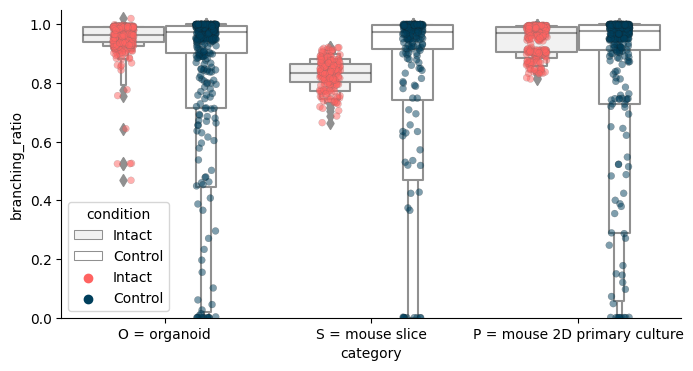

In [2]:
names = ["Organoid", "Mouse slice", "Mouse 2D primary culture"]
# k_max = 2500
# binsz = 10  # Define binsz if not already defined

# Read CSV into dataframe
df = pd.read_csv('br_data.csv')

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

# Define a custom color palette
custom_palette = {'Intact': '#ff6361', 'Control': '#003f5c'}  # Replace with your desired colors

sns.boxenplot(x='category', y='branching_ratio', hue = 'condition', color = 'white', data=df, ax=ax)

sns.stripplot(x='category', y='branching_ratio', hue='condition', data=df, palette=custom_palette, ax=ax, dodge=True, ec = 'k', linewidth = 0.2, alpha = 0.5)

ax.set_ylim(0.0, 1.05)

sns.despine()

plt.legend(title='condition')


In [4]:
df.columns

Index(['Unnamed: 0', 'branching_ratio', 'category', 'condition', 'prep_id'], dtype='object')

In [5]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R
# Load necessary library
library(lme4)
library(emmeans)

# Read the CSV file into a data frame
br_data <- read.csv("br_data.csv")

# View the structure of your data frame
str(br_data)

# Perform the linear mixed-effects regression
# This model tests the effect of CATEGORY (organoid, slice, culture) and CONDITION (intact versus shuffle) on Branching Ratio,
# with a random effect for PREP ID

model = lmer(branching_ratio ~ category*condition + (1 | prep_id), data = br_data)

# Print the summary
summary(model)


R[write to console]: Loading required package: Matrix



'data.frame':	1800 obs. of  5 variables:
 $ X              : int  0 1 2 3 4 5 6 7 8 9 ...
 $ branching_ratio: num  0.95 0.911 0.923 0.992 0.991 ...
 $ category       : chr  "O = organoid" "O = organoid" "O = organoid" "O = organoid" ...
 $ condition      : chr  "Intact" "Intact" "Intact" "Intact" ...
 $ prep_id        : chr  "O2" "O3" "O2" "O5" ...
Linear mixed model fit by REML ['lmerMod']
Formula: branching_ratio ~ category * condition + (1 | prep_id)
   Data: br_data

REML criterion at convergence: -1259

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3994 -0.0596  0.1205  0.5116  1.0429 

Random effects:
 Groups   Name        Variance  Std.Dev.
 prep_id  (Intercept) 0.0007713 0.02777 
 Residual             0.0281656 0.16783 
Number of obs: 1800, groups:  prep_id, 18

Fixed effects:
                                                       Estimate Std. Error
(Intercept)                                           8.828e-01  1.292e-02
categoryP = mouse 2D primary culture 

In [7]:
%%R
# This will give us feedback about whether the main effects are significant 
anova(model)

Analysis of Variance Table
                   npar  Sum Sq Mean Sq F value
category              2 0.29359 0.14680  5.2119
condition             1 0.87533 0.87533 31.0779
category:condition    2 1.27373 0.63686 22.6114


In [9]:
%%R
emmeans(model, list(pairwise ~ category | condition), adjust = 'tukey')

$`emmeans of category | condition`
condition = Control:
 category                     emmean     SE   df lower.CL upper.CL
 O = organoid                  0.883 0.0129 24.1    0.856    0.909
 P = mouse 2D primary culture  0.878 0.0149 24.1    0.847    0.908
 S = mouse slice               0.885 0.0183 24.1    0.848    0.923

condition = Intact:
 category                     emmean     SE   df lower.CL upper.CL
 O = organoid                  0.955 0.0129 24.1    0.929    0.982
 P = mouse 2D primary culture  0.950 0.0149 24.1    0.919    0.981
 S = mouse slice               0.830 0.0183 24.1    0.792    0.868

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of category | condition`
condition = Control:
 2                                              estimate     SE   df t.ratio
 O = organoid - P = mouse 2D primary culture     0.00527 0.0197 24.1   0.267
 O = organoid - S = mouse slice                 -0.00259 0.0224 24.1  -0.116
 P = mouse 2D 

In [10]:
%%R
emmeans(model, list(pairwise ~ condition | category), adjust = 'tukey')

$`emmeans of condition | category`
category = O = organoid:
 condition emmean     SE   df lower.CL upper.CL
 Control    0.883 0.0129 24.1    0.856    0.909
 Intact     0.955 0.0129 24.1    0.929    0.982

category = P = mouse 2D primary culture:
 condition emmean     SE   df lower.CL upper.CL
 Control    0.878 0.0149 24.1    0.847    0.908
 Intact     0.950 0.0149 24.1    0.919    0.981

category = S = mouse slice:
 condition emmean     SE   df lower.CL upper.CL
 Control    0.885 0.0183 24.1    0.848    0.923
 Intact     0.830 0.0183 24.1    0.792    0.868

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$`pairwise differences of condition | category`
category = O = organoid:
 2                estimate     SE   df t.ratio p.value
 Control - Intact  -0.0726 0.0119 1779  -6.116  <.0001

category = P = mouse 2D primary culture:
 2                estimate     SE   df t.ratio p.value
 Control - Intact  -0.0725 0.0137 1779  -5.290  <.0001

category = S = mouse slice:
